Someones Code of a working SIFT class: https://lerner98.medium.com/implementing-sift-in-python-36c619df7945

In [266]:
import numpy as np 
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/

SIFT:
- Can find similarities in images using keypoints, with allowable change in scale and rotation!

Can be divided into 4 parts:
1. Constructing a Scale Space
2. Keypoint Localization
3. Orientation Assignment
4. Keypoint Descriptor

## 1. Constructing a Scale Space:

GUASSIAN BLURRING:

Guassian Blurring to reduce the noise in the image (basically blurs the image, only relevent information like the hape and edges remain left)

Need to ensure that the features must not be scale-dependant, therefore we must search for scales on multiple scales -> create a scae space

Scale space -> is a collection of images having different scales, generated from a single image.

We scale the image by half 4 times (4 octaves), and we blur each octave or scaled image 4 times (5 images including the original scaled image)

Using Skimage to blur the image: https://datacarpentry.org/image-processing/06-blurring/

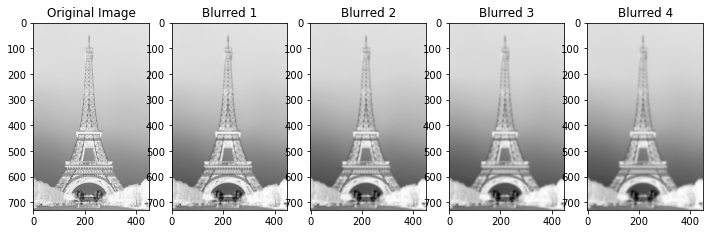

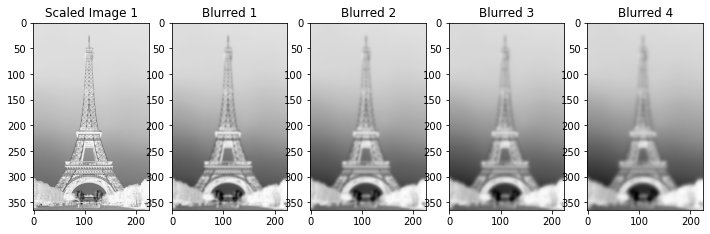

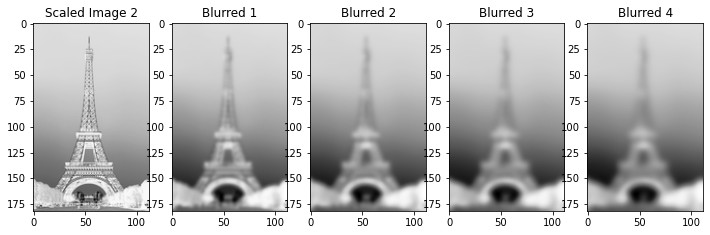

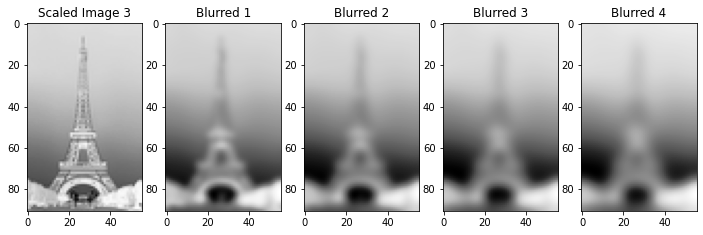

In [268]:
import skimage

sigma = 1.6
filename = r"C:\Users\Sean\Desktop\Image-Retrieval\SIFT_testing_image.PNG"

image = Image.open(filename)

guassian_blurred_images = []

for ii in range(0,4):
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 10))
    
    if ii > 0:
        title = "Scaled Image {}".format(ii)
    else:
        title = "Original Image"
        
    if ii == 0:
        gray_image = ImageOps.grayscale(image)
        image_array = np.array(gray_image)
        scaled_image = image_array
        display_image = scaled_image
    else:
        shape = image.size
        image = image.resize((int(shape[0]/2), int(shape[1]/2)), Image.ANTIALIAS)
        gray_image = ImageOps.grayscale(image)
        image_array = np.array(gray_image)
        scaled_image = image_array
        display_image = scaled_image
        
    for i, ax in enumerate(axes.ravel()):
        if i > 0:
            display_image = skimage.filters.gaussian(display_image, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        ax.imshow(display_image, cmap="Greys")
        
        # saving the display image to an array for future use:
        guassian_blurred_images.append(display_image)
        
        if i > 0:
            ax.set_title("Blurred {}".format(i))
        else:
            ax.set_title(title)

DIFFERENCE OF GUASSIAN (DoG):

Next step is to enhance the features using DoG:
- This is done by subtracting a blurred image from an original or less blurred image

We subtract on the same scale obvisiouly, and hence create 4 images per scale

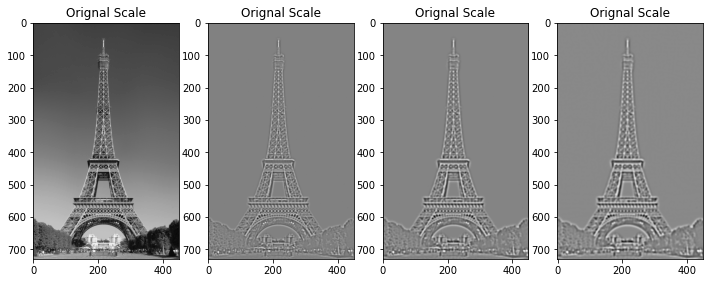

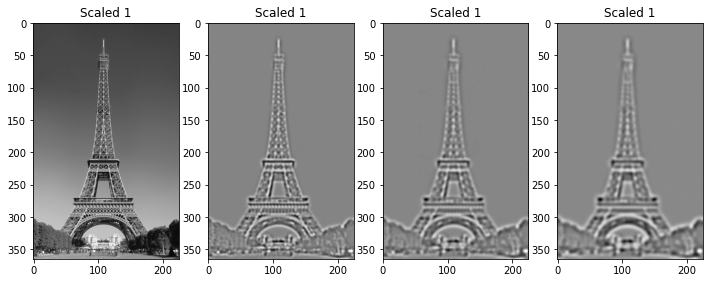

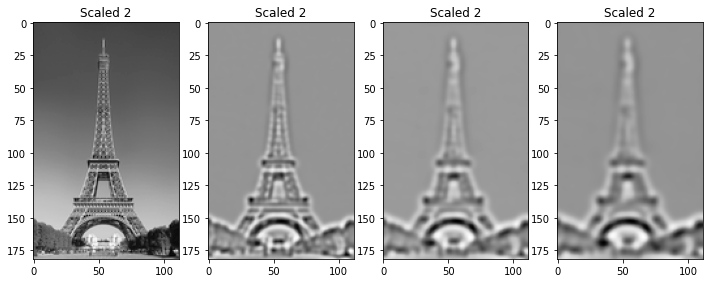

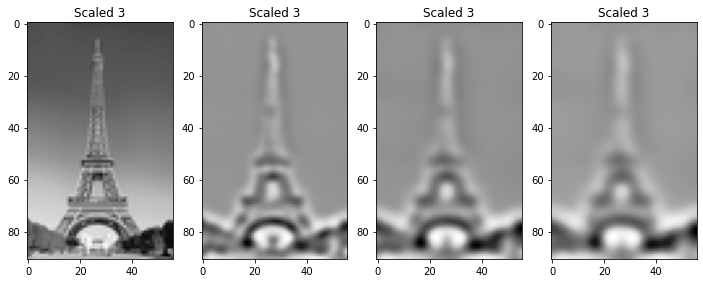

In [277]:
DoG_images = []

x = 0
for ii in range(0,4):
    fig, axes = plt.subplots(1, 4, figsize=(12, 10))

    for i, ax in enumerate(axes.ravel()):
        new_image = guassian_blurred_images[i+1+x] - guassian_blurred_images[i+x]

        ax.imshow(new_image, cmap="Greys")
        
        # Saving the images into an array for future use
        DoG_images.append(new_image)
        
        if ii == 0:
            ax.set_title("Orignal Scale")
        else:
            ax.set_title("Scaled {}".format(ii))
    x += 5

## 2. Keypoint Localization:

Next step is to find the important keypoints from the images!

The idea is to find the local maxima and minima for the images:
1. Find local maxima and minima
2. Remove low contrast keypoints (keypoint selection)

LOCAL MAXIMA & MINIMA:

To locate these points we go through each pixel in the image and compare it to its neighbouring pixels.

The neighbouring pixels include the pixels in its own image but also the pixels in the same spot from the DoG images from the 4 images

We take 3 images from each scale (say the original scale) and we look at the 9 pixels in the above, below, and current image (26 pixels, not including the pixel we are looking at), and it is selected as a keypoint if that pixel is the highest or lowest!

In [281]:
# Using the 3 original scaled images (not the original one, so the blurred DoG images)

octave1_keypoints = []
octave2_keypoints = []
octave3_keypoints = []
octave4_keypoints = []

x = 0
for octave in range(1,5):
    top_image = DoG_images[x]
    current_image = DoG_images[x+1]
    bottom_image = DoG_images[x+2]

    for r in range(current_image.shape[0]):
        for c in range(current_image.shape[1]):
            # Cannot be on the edges as we cannot take the 3x3 window around the pixel
            if r != 0 and r != current_image.shape[0]-1 and c != 0 and c != current_image.shape[1]-1:
                neighbouring_pixel_values = []
                current_pixel_value = current_image[r][c]
                # check if this pixel value is the highest or lowest from its neighbouring pixels
                neighbouring_pixel_values.append(current_image[r+1][c+1])
                neighbouring_pixel_values.append(current_image[r+1][c])
                neighbouring_pixel_values.append(current_image[r+1][c-1])
                neighbouring_pixel_values.append(current_image[r-1][c+1])
                neighbouring_pixel_values.append(current_image[r-1][c])
                neighbouring_pixel_values.append(current_image[r-1][c-1])
                neighbouring_pixel_values.append(current_image[r][c+1])
                neighbouring_pixel_values.append(current_image[r][c-1])

                neighbouring_pixel_values.append(top_image[r+1][c+1])
                neighbouring_pixel_values.append(top_image[r+1][c])
                neighbouring_pixel_values.append(top_image[r+1][c-1])
                neighbouring_pixel_values.append(top_image[r-1][c+1])
                neighbouring_pixel_values.append(top_image[r-1][c])
                neighbouring_pixel_values.append(top_image[r-1][c-1])
                neighbouring_pixel_values.append(top_image[r][c+1])
                neighbouring_pixel_values.append(top_image[r][c])
                neighbouring_pixel_values.append(top_image[r][c-1])

                neighbouring_pixel_values.append(bottom_image[r+1][c+1])
                neighbouring_pixel_values.append(bottom_image[r+1][c])
                neighbouring_pixel_values.append(bottom_image[r+1][c-1])
                neighbouring_pixel_values.append(bottom_image[r-1][c+1])
                neighbouring_pixel_values.append(bottom_image[r-1][c])
                neighbouring_pixel_values.append(bottom_image[r-1][c-1])
                neighbouring_pixel_values.append(bottom_image[r][c+1])
                neighbouring_pixel_values.append(bottom_image[r][c])
                neighbouring_pixel_values.append(bottom_image[r][c-1])

                greatest_count = 0
                lowest_count = 0
                for pixel_value in neighbouring_pixel_values:
                    if current_pixel_value > pixel_value:
                        greatest_count += 1
                    elif current_pixel_value < pixel_value:
                        lowest_count += 1

                if greatest_count == len(neighbouring_pixel_values) or lowest_count == len(neighbouring_pixel_values):
                    if octave == 1:
                        octave1_keypoints.append((r,c))
                    elif octave == 2:
                        octave2_keypoints.append((r,c))
                    elif octave == 3:
                        octave3_keypoints.append((r,c))
                    elif octave == 4:
                        octave4_keypoints.append((r,c))

    if octave == 1:
         print("Octave {} number of keypoints: {}".format(octave, len(octave1_keypoints)))
    elif octave == 2:
         print("Octave {} number of keypoints: {}".format(octave, len(octave2_keypoints)))
    elif octave == 3:
         print("Octave {} number of keypoints: {}".format(octave, len(octave3_keypoints)))
    elif octave == 4:
         print("Octave {} number of keypoints: {}".format(octave, len(octave4_keypoints)))
    x += 4

Octave 1 number of keypoints: 6922
Octave 2 number of keypoints: 1644
Octave 3 number of keypoints: 351
Octave 4 number of keypoints: 61


KEYPOINT SELECTION:

How do you solve taylor series expansion on each keypoint?\
If D(x) less than 0.03 we get rid of that keypoint -> where D(x) is the Taylor Series Expansion

- why is there 0 keypoints across the last 3 images of each octave?
- Why is there such a large number of keypoints w.r.t the first image (orignal scaled ones)?
- How do all of these keypoints make it to one image, as they all have different sizes and scales?
- Is my guassian blurring and DoG implemented correctly?